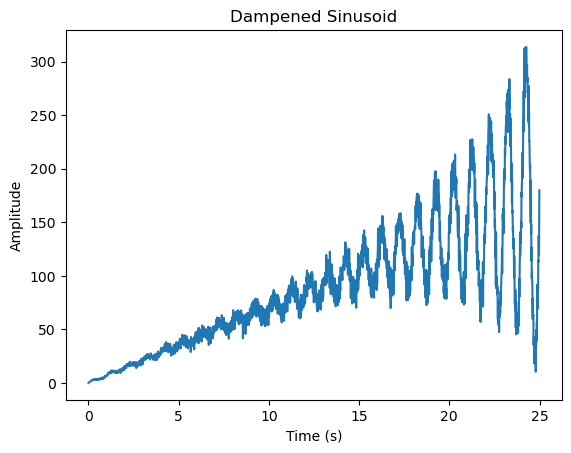

In [13]:
import numpy as np
#Import the Generator from utils- Reload the module to get the latest version
from importlib import reload
import utils
reload(utils)
from utils import series_generator
import matplotlib.pyplot as plt



#Simulate and plot a dampened sinusoid in time



#Genrate the series

y, y_train, y_test, t = series_generator(2500)



# Plot the function
plt.plot(t, y)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Dampened Sinusoid')
plt.show()



In [14]:
import Models
reload(Models)
from Models import Net
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

#Divide the data into training and testing sets. The first 1500 time steps of y will be used for training and the last 1000 for testing.

y_train = y[0:1500]
y_test = y[1500:2500]

#Define the model, loss function, and optimizer and train it for 100 epochs.

net = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), weight_decay=1e-5)

for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in range(0, 1300, 50):
        # get the inputs; data is a list of [inputs, labels]
        inputs=y_train[i:i+200]
        inputs = torch.tensor(inputs)
        labels = torch.tensor(y_train[i+200:i+250])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('[%d] loss: %.10f' %
            (epoch + 1, running_loss / 26))
    running_loss = 0.0

print('Finished Training')

[1] loss: 546.8977655264
[2] loss: 107.6873852656
[3] loss: 81.1376220997
[4] loss: 71.7838761623
[5] loss: 71.2263302436
[6] loss: 65.3268660032
[7] loss: 66.1380562415
[8] loss: 72.4215487700
[9] loss: 58.6225380531
[10] loss: 61.5819627322
[11] loss: 56.0550564986
[12] loss: 56.6260689222
[13] loss: 52.7836034481
[14] loss: 51.9551679905
[15] loss: 55.7384317838
[16] loss: 52.6197329301
[17] loss: 48.9631284567
[18] loss: 47.7727632523
[19] loss: 46.3421457731
[20] loss: 45.1175490893
[21] loss: 43.6380103918
[22] loss: 42.2143583298
[23] loss: 40.1303935418
[24] loss: 38.5804346525
[25] loss: 36.6550164956
[26] loss: 35.1480913529
[27] loss: 34.2839557941
[28] loss: 34.5490792348
[29] loss: 34.2480621338
[30] loss: 34.7241774156
[31] loss: 34.7170838759
[32] loss: 34.7069047781
[33] loss: 34.7753748894
[34] loss: 34.5587039544
[35] loss: 34.5131422190
[36] loss: 34.0993729004
[37] loss: 33.6759264286
[38] loss: 33.4725405620
[39] loss: 33.1097889313
[40] loss: 32.5976835764
[41] lo

In [15]:
#Test the model on the entire data set and plot the results.

y_pred = []
for i in range(0, 2300, 50):
    inputs=y[i:i+200]
    inputs = torch.tensor(inputs)
    outputs = net(inputs.float())
    y_pred.append(outputs.detach().numpy())

y_pred = np.array(y_pred)
y_pred = y_pred.reshape(2300)

#plot with plotly with a line where the training set ends
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=t[0:2500], y=y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=t[200:2500], y=y_pred, mode='lines', name='Predicted'))
fig.add_trace(go.Scatter(x=[t[1500], t[1500]], y=[-20, 150], mode='lines', name='Training Set End'))
fig.update_layout(title='Dampened Sinusoid', xaxis_title='Time (s)', yaxis_title='Amplitude')
fig.show()

#Compute the total error on the test set.
error = 0
for i in range(1500, 2500):
    error = error + (y[i] - y_pred[i-200])**2
error = error/1000
print(error)


524.0496265202603


Optimal parameters:  alpha_mu = 0.29472041696191176,  alpha_sigma = 0.03507467659719357, mu_0 = 0.6296448032580595, sigma2_0 = 0.1061366202151006


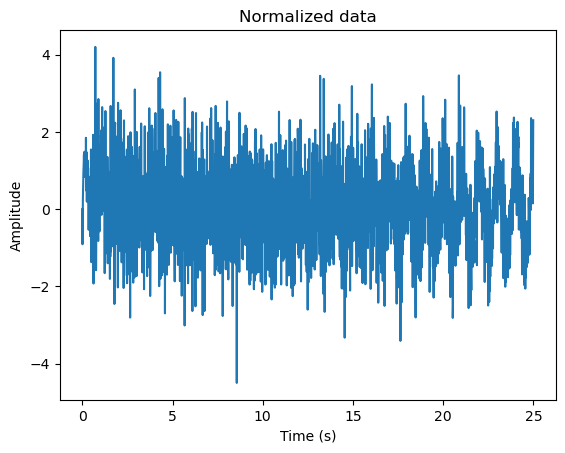

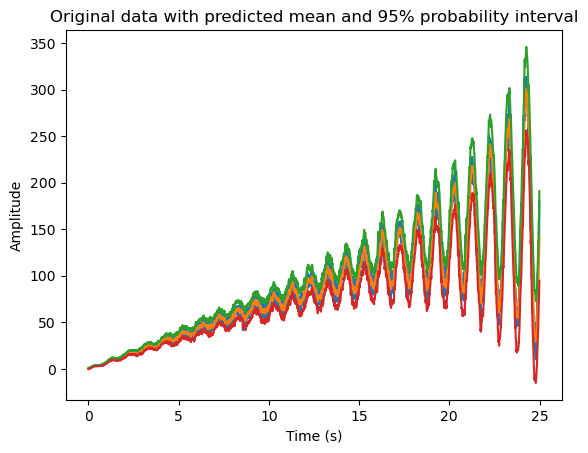

The share of points that are outside the 95% variability interval is 0.44%
The share of y t+1 that are outside the 95% variability interval is 6.36%


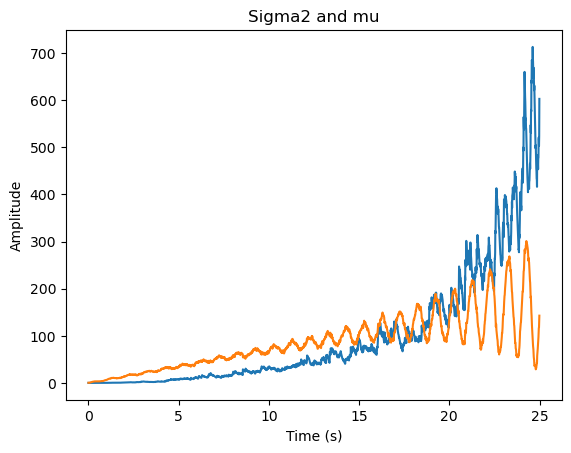

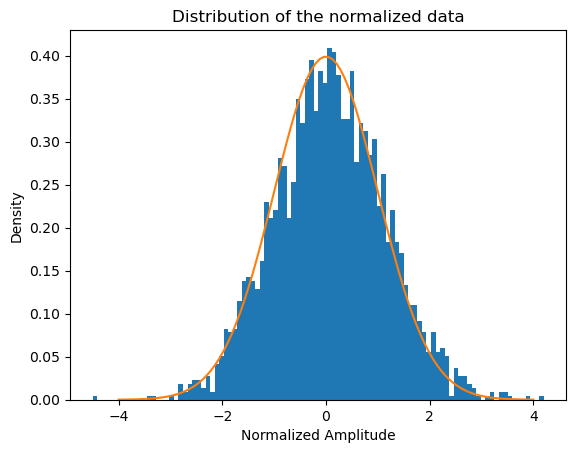

In [16]:
import GAS_norm
reload(GAS_norm)
from GAS_norm import SD_Normalization_Gaussian 
import numpy as np


mu_list, sigma2_list, y_norm = SD_Normalization_Gaussian(y, y_train, 'Full', mode='predict')


#Plot the normalized data

plt.plot(t[0:2500], y_norm)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Normalized data')
plt.show()

#Plot the original data with the predicted mean and 95% variability interval

plt.plot(t[0:2500], y)
plt.plot(t[0:2500], mu_list)
plt.plot(t[0:2500], mu_list+1.96*np.sqrt(sigma2_list))
plt.plot(t[0:2500], mu_list-1.96*np.sqrt(sigma2_list))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Original data with predicted mean and 95% probability interval')
plt.show()

#Write the share of points that are outside the 95% variability interval

share = np.sum((y > mu_list+1.96*np.sqrt(sigma2_list)) | (y < mu_list-1.96*np.sqrt(sigma2_list)))/len(y)
print("The share of points that are outside the 95% variability interval is {}%".format(share*100))

#Write the share of y_{t+1} that are outside the 95% variability interval

share = np.sum((y[1:] > mu_list[0:-1]+1.96*np.sqrt(sigma2_list[0:-1])) | (y[1:] < mu_list[0:-1]-1.96*np.sqrt(sigma2_list[0:-1])))/len(y)
print("The share of y t+1 that are outside the 95% variability interval is {}%".format(share*100))

#Plot sigma_list and mu_list in the same plot
plt.plot(t[0:2500], sigma2_list)
plt.plot(t[0:2500], mu_list)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Sigma2 and mu')
plt.show()

#Plot the distributino of the normalized data and compare it with a standard normal distribution

import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

plt.hist(y_norm, bins=100, density=True)
plt.plot(np.linspace(-4, 4, 100), stats.norm.pdf(np.linspace(-4, 4, 100), 0, 1))
plt.xlabel('Normalized Amplitude')
plt.ylabel('Density')
plt.title('Distribution of the normalized data')
plt.show()



In [17]:
#Redo the training with the new strategy
import Models
reload(Models)
from Models import GAS_Net
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

#Normalize data and extract means and variances
mu_list, sigma2_list, y_norm = SD_Normalization_Gaussian(y, y_train, regularization='Full')

#Divide the data into training and testing sets. The first 1500 time steps of y will be used for training and the last 1000 for testing.

y_train = y[0:1500]
y_test = y[1500:2500]
y_norm_train = y_norm[0:1500]
y_norm_test = y_norm[1500:2500]

#Define the model, loss function, and optimizer and train it for 100 epochs.
#The training is divided in more phases to avoid gradients size problems.
#We first train only the mu layer to make linear predictions with mean information. All the rest is set to zero. 
#Then we fix the mu layer and train the nonlinear part. 
#Fianllly we train the sigma layer.


gas_net = GAS_Net()
gas_net.float()
criterion = nn.MSELoss()
model_parameters = gas_net.named_parameters()
optimizer_mu = optim.Adam([param for name, param in model_parameters if 'mu_layer' in name], weight_decay=1e-5)
model_parameters = gas_net.named_parameters()
optimizer_eps = optim.Adam([param for name, param in model_parameters if 'fc1' in name or 'fc2' in name or 'fc3' in name or 'relu' in name], weight_decay=1e-5)
model_parameters = gas_net.named_parameters()
optimizer_sigma = optim.Adam([param for name, param in model_parameters if 'sigma_layer' in name], weight_decay=1e-5)
optimizer_list = [optimizer_mu, optimizer_eps, optimizer_sigma]

for phase in range(3):
    optimizer = optimizer_list[phase]
    for epoch in range(100):  # loop over the dataset multiple times
        running_loss = 0.0
        for i in range(0, 1300, 50):
            # get the inputs; data is a list of [inputs, labels]
            
            inputs=y_norm_train[i:i+200]
            inputs = torch.tensor(inputs)
            labels = torch.tensor(y_train[i+200:i+250])
            mu_vector = torch.tensor(mu_list[i:i+200])
            sigma2_vector = torch.tensor(sigma2_list[i:i+200])

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = gas_net(inputs.float(), mu_vector.float(), sigma2_vector.float(), phase)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        print('[%d] loss: %.10f' %
                (epoch + 1, running_loss / 26))
        running_loss = 0.0

print('Finished Training')

Optimal parameters:  alpha_mu = 0.29472041696191176,  alpha_sigma = 0.03507467659719357, mu_0 = 0.6296448032580595, sigma2_0 = 0.1061366202151006
[1] loss: 266.3399335421
[2] loss: 134.0756925436
[3] loss: 123.2040367126
[4] loss: 119.0065718431
[5] loss: 115.3234932239
[6] loss: 112.0105312054
[7] loss: 109.7202281952
[8] loss: 107.8680397914
[9] loss: 106.1851244706
[10] loss: 103.9291273264
[11] loss: 101.3091206184
[12] loss: 98.8171310425
[13] loss: 97.0553772266
[14] loss: 95.9444271968
[15] loss: 95.2646658971
[16] loss: 94.6613047673
[17] loss: 93.9176153036
[18] loss: 92.9108337989
[19] loss: 91.7047229180
[20] loss: 90.4376027767
[21] loss: 89.2632245284
[22] loss: 88.2617086264
[23] loss: 87.4552709873
[24] loss: 86.8218832016
[25] loss: 86.3310252703
[26] loss: 85.9516027157
[27] loss: 85.6618027320
[28] loss: 85.4457544180
[29] loss: 85.2943245814
[30] loss: 85.2014314211
[31] loss: 85.1633654374
[32] loss: 85.1767950058
[33] loss: 85.2385377150
[34] loss: 85.3448760693
[3

In [27]:
#Test the model on the entire data set and plot the results.

y_pred = []
for i in range(0, 2300, 50):
    inputs=y_norm[i:i+200]
    inputs = torch.tensor(inputs)
    mu_vector = torch.tensor(mu_list[i:i+200])
    sigma2_vector = torch.tensor(sigma2_list[i:i+200])
    outputs = gas_net(inputs.float(), mu_vector.float(), sigma2_vector.float(), 0)
    y_pred.append(outputs.detach().numpy())

y_pred = np.array(y_pred)
y_pred = y_pred.reshape(2300)

#plot with plotly with a line where the training set ends

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=t[0:2500], y=y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=t[200:2500], y=y_pred, mode='lines', name='Predicted'))
fig.add_trace(go.Scatter(x=[t[1500], t[1500]], y=[-20, 150], mode='lines', name='Training Set End'))
fig.update_layout(title='Dampened Sinusoid', xaxis_title='Time (s)', yaxis_title='Amplitude')
fig.show()

#Compute the total error on the test set.

error = 0
for i in range(1500, 2500):
    error = error + (y[i] - y_pred[i-200])**2
error = error/1000
print(error)

297.71959865994336


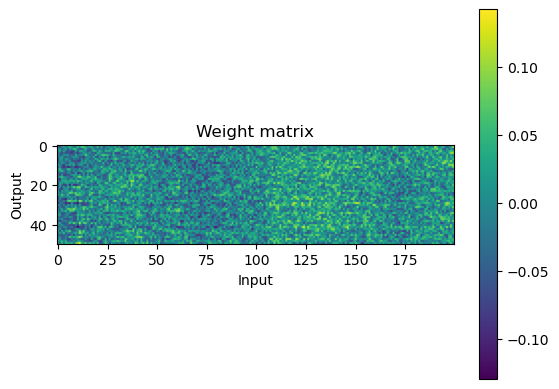

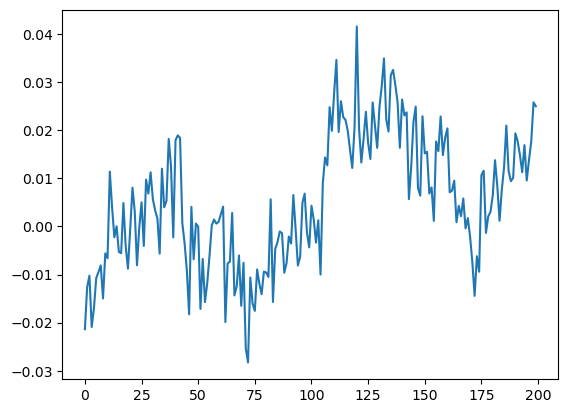

In [28]:
#Plot the weight matrix of the last layer of the network as an heatmap and add the legend of the colorbar

weights = gas_net.mu_layer.weight.detach().numpy()
plt.imshow(weights)
plt.colorbar()
plt.xlabel('Input')
plt.ylabel('Output')
plt.title('Weight matrix')

plt.show()

#Now plot the mean of the weights with respect to each input

weights = gas_net.mu_layer.weight.detach().numpy()
plt.plot(weights.mean(axis=0))






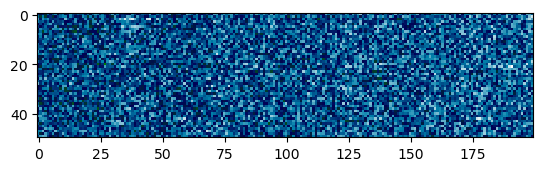

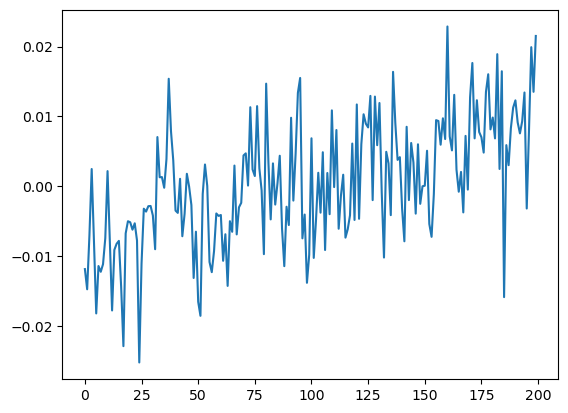

In [ ]:
#Plot the weight matrix of the last layer of the network as an heatmap

weights = net.sigma_layer.weight.detach().numpy()
plt.imshow(weights, interpolation='nearest', cmap=plt.cm.ocean)

plt.show()

#Now plot the mean of the weights with respect to each input

weights = net.sigma_layer.weight.detach().numpy()
plt.plot(weights.mean(axis=0))


In [ ]:
#Define a neural network class that use Revin as normalization procedure
#Revin expect the input and output to be (batch, time, features) so we need to reshape the data
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils


In [ ]:
import Models
reload(Models)
from Models import Revin_Net

#Divide the data into training and testing sets. The first 1500 time steps of y will be used for training and the last 1000 for testing.

y_train = y[0:1500]
y_test = y[1500:2500]

#Define the model, loss function, and optimizer and train it for 100 epochs.

net = Revin_Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), weight_decay=1e-5)

for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i in range(0, 1300, 50):
        # get the inputs; data is a list of [inputs, labels]
        inputs=y_train[i:i+200]
        inputs = torch.tensor(inputs)
        labels = torch.tensor(y_train[i+200:i+250])

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
    print('[%d] loss: %.10f' %
            (epoch + 1, running_loss / 26))
    running_loss = 0.0

print('Finished Training')

[1] loss: 82.6671849031
[2] loss: 33.2039617942
[3] loss: 30.7330378386
[4] loss: 21.2796502664
[5] loss: 18.6865424009
[6] loss: 16.7645759583
[7] loss: 15.3523362233
[8] loss: 14.1638511969
[9] loss: 12.8958724462
[10] loss: 12.1261236484
[11] loss: 11.1646358417
[12] loss: 10.7863727670
[13] loss: 11.0795669647
[14] loss: 9.8609426572
[15] loss: 13.0255491275
[16] loss: 9.0541196786
[17] loss: 12.9629150354
[18] loss: 7.6910328498
[19] loss: 7.7352468830
[20] loss: 5.6397236127
[21] loss: 6.1902700502
[22] loss: 5.9347337301
[23] loss: 5.8419101834
[24] loss: 5.1157493385
[25] loss: 6.8101447844
[26] loss: 5.9740957068
[27] loss: 5.5643712603
[28] loss: 7.4293204913
[29] loss: 8.1187100410
[30] loss: 7.8613495918
[31] loss: 10.3773687161
[32] loss: 7.3030073734
[33] loss: 7.3380021270
[34] loss: 6.9500986544
[35] loss: 5.7916277051
[36] loss: 5.5626977545
[37] loss: 3.8505381025
[38] loss: 4.5846842642
[39] loss: 4.6348875073
[40] loss: 3.8959958324
[41] loss: 3.7555728348
[42] loss

In [ ]:
#Test the model on the entire data set and plot the results.

y_pred = []
for i in range(0, 2300, 50):
    inputs=y[i:i+200]
    inputs = torch.tensor(inputs)
    outputs = net(inputs.float())
    y_pred.append(outputs.detach().numpy())

y_pred = np.array(y_pred)
y_pred = y_pred.reshape(2300)

#plot with plotly with a line where the training set ends
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=t[0:2500], y=y, mode='lines', name='Actual'))
fig.add_trace(go.Scatter(x=t[200:2500], y=y_pred, mode='lines', name='Predicted'))
fig.add_trace(go.Scatter(x=[t[1500], t[1500]], y=[-20, 150], mode='lines', name='Training Set End'))
fig.update_layout(title='Dampened Sinusoid', xaxis_title='Time (s)', yaxis_title='Amplitude')
fig.show()

#Compute the total error on the test set.
error = 0
for i in range(1500, 2500):
    error = error + (y[i] - y_pred[i-200])**2
error = error/1000
print(error)

1137.4547843520088
